# 01_Perturbation-Based

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16()
model.summary()

2022-04-28 17:11:57.821743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-28 17:11:57.822618: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-28 17:11:57.822855: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
def load_imagenet_labels(labels_file):
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('data/ImageNetLabels.txt')

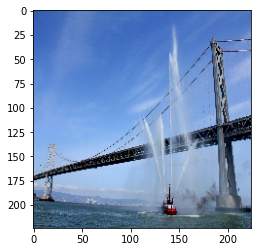

In [20]:
def read_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
#     image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

image = read_image('data/fireboat.jpg')
plt.imshow(image/255)

In [18]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    inputs = preprocess_input(image_batch)
    predictions = model(inputs)
    top_probs, top_idxs = tf.math.top_k(input=predictions, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

In [19]:
pred_label, pred_prob = top_k_predictions(image)
for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

fireboat: 98.6%
drilling platform: 0.3%
crane: 0.2%


## [Occlusion Sensitivity (Zeiler & Fergus 14)](https://arxiv.org/abs/1311.2901)

In [7]:
batch_size = 16
patch_size = 32
class_index = 555
grid = math.ceil(image.shape[0]/patch_size)

In [8]:
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    
    patched_image = np.array(image, copy=True)
    patched_image[
        top_left_y : top_left_y + patch_size, top_left_x : top_left_x + patch_size, :
    ] = 127.5

    return patched_image

In [9]:
sensitivity_map = np.zeros(
    (
        math.ceil(image.shape[0] / patch_size),
        math.ceil(image.shape[1] / patch_size),
    )
)

patches = [
    apply_grey_patch(image, top_left_x, top_left_y, patch_size)
    for index_x, top_left_x in enumerate(range(0, image.shape[0], patch_size))
    for index_y, top_left_y in enumerate(range(0, image.shape[1], patch_size))
]

coordinates = [
    (index_y, index_x)
    for index_x in range(
        sensitivity_map.shape[1]  # pylint: disable=unsubscriptable-object
    )
    for index_y in range(
        sensitivity_map.shape[0]  # pylint: disable=unsubscriptable-object
    )
]

In [10]:
inputs = preprocess_input(np.array(patches))
predictions = model.predict(inputs, batch_size=batch_size)

target_class_probs = [
    prob[class_index] for prob in predictions
]

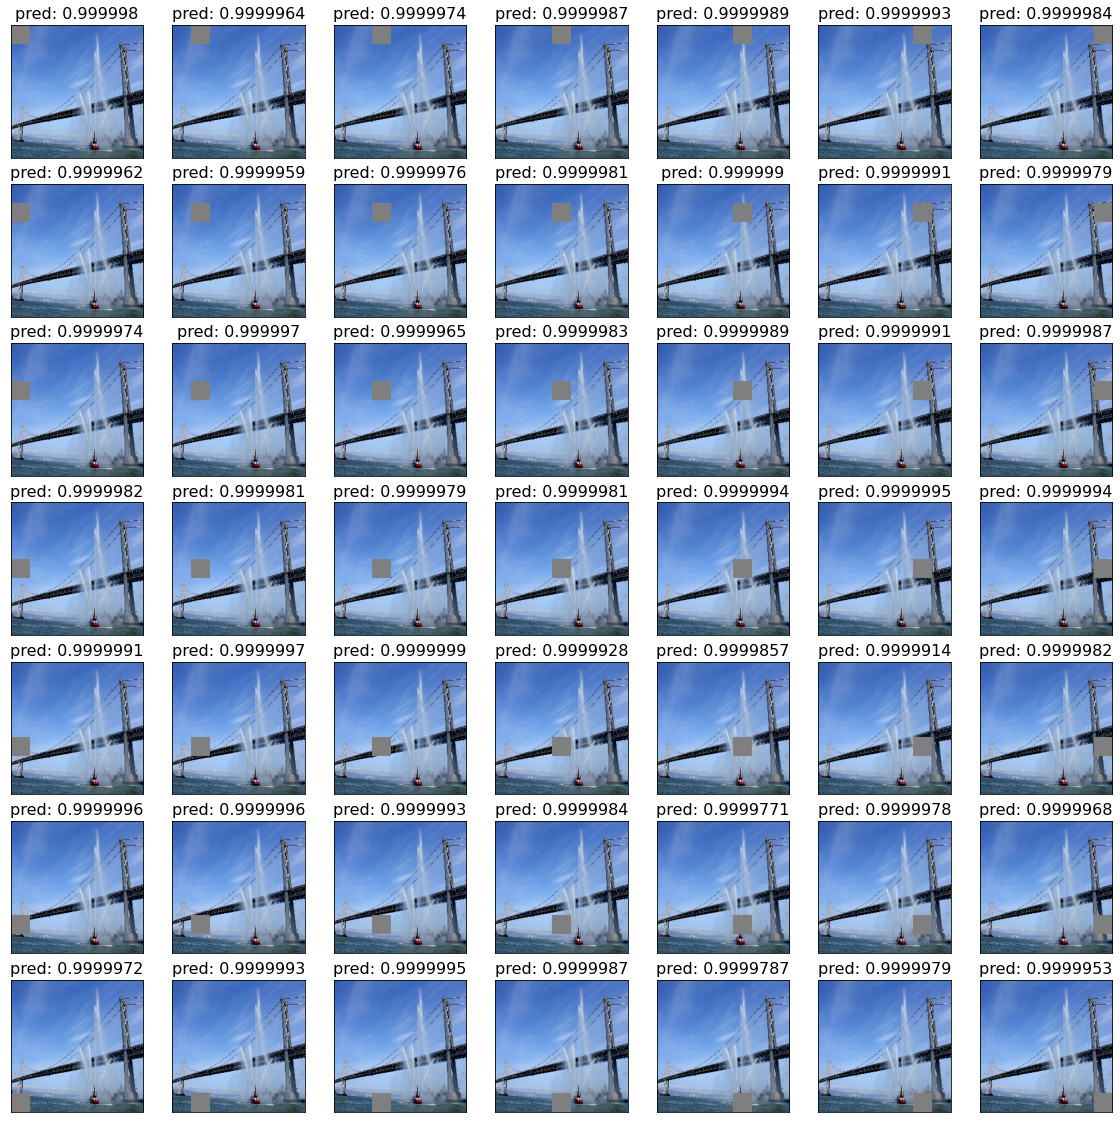

In [11]:
fig, ax = plt.subplots(nrows=grid, ncols=grid, figsize=(20, 20),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.2, wspace=0.1))
for i in range(len(patches)):
    ax[i%grid, i//grid].set_title('pred: '+ str(round(1-target_class_probs[i], 7)), fontsize=16)
    ax[i%grid, i//grid].imshow(patches[i]/255)

In [12]:
for (index_y, index_x), confidence in zip(
    coordinates, target_class_probs
):
    sensitivity_map[index_y, index_x] = 1 - confidence
    
sensitivity_maps = cv2.resize(sensitivity_map, image.shape[0:2])

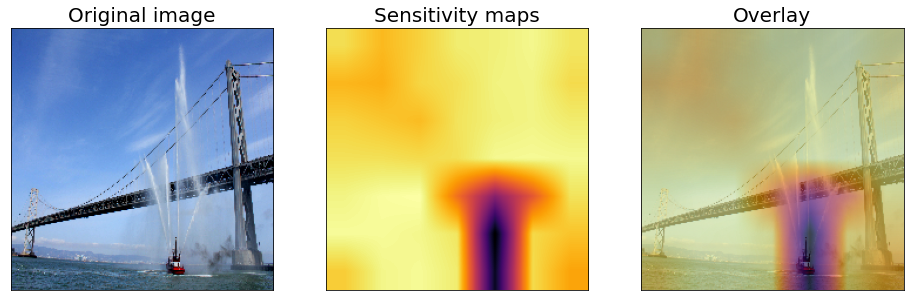

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity maps', fontsize=20)
axs[0, 1].imshow(sensitivity_maps, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(sensitivity_maps, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

## 練習時間：
### 自己更改 patch_size 練習看看